# Design and Manufacturing Workflow

Members: Viraj Kanchan, Nathan Mayer, Shubang Mukund, Matthew Nolan

Code Adapted from the Full Design Pipeline Code Written by Professor Daniel Aukes

## Paper Mockup

<img src='https://drive.google.com/uc?id=1qMZy7Rk5euNUeHa2wFz1bZfjoFotDzME' width="500">
<img src='https://drive.google.com/uc?id=1n9_0YEGxklgF7K_JJC__aFEJhOj3S5Ab' width="500">

Note that the "end effector" link (the one in contact with the ground) will not be represented in this assignment because it will be manufactured separately in the final product. This is to facilitate materials testing of the final link to tune the springiness while leaving the other links as stiff as possible. 

## Solidworks Drawings and Models

The first image below shows the flat pattern for the five-bar mechanism. 

<img src='https://drive.google.com/uc?id=1y3OnKw-u7-ojnEPwmW3vjdwT6jAi6sYr' width="1000">





The left image below shows the mechanism in its folded state with the flexible end-effector link attached, while the right image shows the mechanism on its own.

<img src='https://drive.google.com/uc?id=1y3qpTQDOYrBIi2T9u4Btn0s6XXEZj_7G' width="500">
<img src='https://drive.google.com/uc?id=1y40RdIwJ99pFBK9oghw_TUznFs_0g0Hw' width="500">

## Install/Import Packages and Define Functions

In [5]:
# possibly necessary installations (needs to run for each new Google Colab session)
!pip install foldable_robotics
!pip install idealab_tools
!pip install PyQt5
!pip install pyqtgraph
!pip install shapely==1.7.1
!pip install -U PyYAML

  Using cached PyQt5-5.15.6-cp36-abi3-manylinux1_x86_64.whl (8.3 MB)
  Using cached PyQt5_Qt5-5.15.2-py3-none-manylinux2014_x86_64.whl (59.9 MB)
  Using cached pyqtgraph-0.12.4-py3-none-any.whl (995 kB)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import Necessary Packages:

In [1]:
import foldable_robotics
import foldable_robotics.dxf 
import numpy
import shapely.geometry as sg
from foldable_robotics.layer import Layer
from foldable_robotics.laminate import Laminate
import foldable_robotics.manufacturing
import foldable_robotics.parts.castellated_hinge1
import idealab_tools.plot_tris
from math import pi, sin,cos,tan
import idealab_tools.text_to_polygons
foldable_robotics.display_height=200
foldable_robotics.line_width=.5

from foldable_robotics.layer import Layer
from foldable_robotics.laminate import Laminate
import foldable_robotics
import foldable_robotics.dxf 
import foldable_robotics.manufacturing
import foldable_robotics.parts.castellated_hinge1
foldable_robotics.display_height=200
foldable_robotics.line_width=.5
#import workflow_support as ws

from os import chdir as cd
import foldable_robotics.solidworks_support
import yaml

In [2]:
# change current working directory to make file importing/exporting easier
cd("/content/drive/Shareddrives/EGR 557 Group Project/Finalized Design and Manufacturing Workflow")

Define All Required Functions:

In [3]:
def get_bodies(filename, layername, num_layers):
    body = foldable_robotics.dxf.read_lwpolylines(filename,layer=layername, arc_approx = 10)

    bodies = [Layer(sg.Polygon(item)) for item in body]
    body = bodies.pop(0)
    for item in bodies:
        body ^= item
    body = body.to_laminate(num_layers)
    return body

In [4]:
def get_hinge_lines(filename,layername):
    hinge_lines1 = foldable_robotics.dxf.read_lines(filename,layer=layername)
    hinge_lines2 = foldable_robotics.dxf.read_lwpolylines(filename,layer=layername)
    hinge_lines3 = []
    for points in hinge_lines2:
        hinge_lines3.append(points[:2])
    hinge_lines = hinge_lines1 +hinge_lines3
    return hinge_lines

In [5]:
def hinge_lines_to_hinges(hinge_lines,hinge):
    lam = Layer().to_laminate(len(hinge))
    all_hinges = []    
    for p3,p4 in hinge_lines:
        all_hinges.append(hinge.map_line_stretch((0,0),(1,0),p3,p4))
    all_hinges = lam.unary_union(*all_hinges)
    return all_hinges

In [6]:
def get_cuts(filename,layername,thickness,num_layers):
    cut_lines = foldable_robotics.dxf.read_lines(filename,layer=layername)
    cut_lines += foldable_robotics.dxf.read_lwpolylines(filename,layer=layername, arc_approx = 10)
    
    cuts = []
    for item in cut_lines:
        cuts.append(Layer(sg.LineString(item)))
    cuts = Layer().unary_union(*cuts)
    cuts<<=thickness/2
    cuts = cuts.to_laminate(num_layers)
    return cuts    

In [7]:
def get_holes(filename, layername,num_layers):
    holes = foldable_robotics.dxf.read_circles(filename,layer='holes')
    
    holes2 = []
    for center, radius in holes:
        holes2.append(sg.Point(*center).buffer(radius))
    holes_layer = Layer(*holes2)
    holes_lam = holes_layer.to_laminate(num_layers)  
    return holes_lam

In [8]:
def hinge_width_calculator(desired_degrees,thickness):
    theta = (180-desired_degrees)*pi/180
    w=thickness/tan(theta)
    return w

In [9]:
def polys_to_layer(l1):
    l1 = [sg.Polygon(item) for item in l1]
    l11 = Layer(l1.pop(0))
    for item in l1:
        l11 ^= Layer(item)
    return l11

In [10]:
def output_pdf(filename,design2,x,y,layers_separate = True):
    design2 = design2.translate(x,y)
    design2=design2.scale(1/25.4,1/25.4)
    design2=design2.scale(foldable_robotics.pdf.ppi,foldable_robotics.pdf.ppi)
    if isinstance(design2,Laminate):
        if not layers_separate:
            p=foldable_robotics.pdf.Page(filename+'.pdf')
            for d in design2:
    #        d = design2[0]
                for item in d.exteriors()+d.interiors():
                    p.draw_poly(item)
            p.close()
        else:
            for ii,d in enumerate(design2):
                p=foldable_robotics.pdf.Page(filename+'{0:03f}.pdf'.format(ii))
                for item in d.exteriors()+d.interiors():
                    p.draw_poly(item)
                p.close()

    elif isinstance(design2,Layer):
        p=foldable_robotics.pdf.Page(filename+'.pdf')
        for item in design2.exteriors()+design2.interiors():
            p.draw_poly(item)
        p.close()

In [11]:
def build_layer_numbers(num_layers, text_size = None, prop=None):
    text_size = text_size or 1
    prop = prop or {'family':'Arial','size':text_size}
    layer_ids = []
    for ii in range(num_layers): 
    
        l = idealab_tools.text_to_polygons.text_to_polygons('Layer '+str(ii),prop=prop)
        layer_ids.append(l)
    
    layer_ids = [polys_to_layer(item) for item in layer_ids]
    layer_id = Laminate(*layer_ids)
    return layer_id

In [12]:
def build_web(design2,keepout,support_width,jig_diameter,jig_hole_spacing,is_adhesive):
    num_layers = len(design2)

    layer_id = build_layer_numbers(num_layers,text_size=jig_diameter)

    design_outer = foldable_robotics.manufacturing.unary_union(design2)
    bb1= (design_outer<<jig_hole_spacing/2).bounding_box()
    (x1,y1),p2 = bb1.bounding_box_coords()
    w,h = bb1.get_dimensions()
    w2 = round(w/jig_hole_spacing)*jig_hole_spacing
    h2 = round(h/jig_hole_spacing)*jig_hole_spacing
    
    points = []
    points.append(sg.Point(x1,y1))
    points.append(sg.Point(x1+w2,y1))
    points.append(sg.Point(x1,y1+h2))
    points.append(sg.Point(x1+w2,y1+h2))
    
    layer_id = layer_id.translate(x1+jig_diameter,y1-jig_diameter/2)
    placement_holes2 = Layer(*points)
    placement_holes2<<=(jig_diameter/2)
    sheet = (placement_holes2<<10).bounding_box()
    placement_holes2=placement_holes2.to_laminate(num_layers)
    sheet=sheet.to_laminate(num_layers)
    
    removable_scrap = calculate_removable_scrap(design2,sheet,support_width,is_adhesive)
    
    web = (removable_scrap-placement_holes2)-layer_id
    return web,sheet

In [13]:
def calculate_removable_scrap(design,sheet,width,is_adhesive):
    '''this computes all removable scrap given a sheet, a design, and a clearance width'''
    all_scrap = sheet-design

    ru = foldable_robotics.manufacturing.not_removable_up(design,is_adhesive)
    rd = foldable_robotics.manufacturing.not_removable_down(design,is_adhesive)
    
    removable_scrap_up = all_scrap-(ru<<width)
    removable_scrap_down = all_scrap-(rd<<width)

    removable_scrap = removable_scrap_up|removable_scrap_down
    return removable_scrap

## Generate DXF From Solidworks File

Load .yaml File (exported from Solidworks:

In [14]:
input_filename = 'final_design.yaml'
output_file_name = 'final_design.dxf' # output file that the solidworks_support.process() function writes to
#output_file_modified = folder+'design_modified.dxf' # modified version of the output file because the process function was badly misbehaving

In [15]:
round_digits = 5
prescale=1000
body_prebuffer=-.01
joint_tolerance = 1e-6

jig_diameter = 5
support_width = 1
kerf = .05
jig_hole_spacing=20
arc_approx = 10

In [16]:
# will not actually use this generated DXF because it takes a billion years! Custom DXF was created instead
#foldable_robotics.solidworks_support.process(input_filename,output_file_name,prescale,round_digits,body_prebuffer,joint_tolerance)

## Single Layer Design

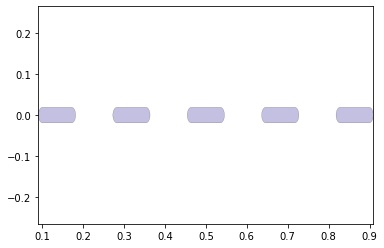

In [ ]:
is_adhesive = [False]
radius = .01
num_perforations = 5
num_segments = num_perforations*2+1
num_points = num_segments+1
a=numpy.r_[0:1:num_points*1j]
lines = []
for ii in range(int(len(a)/2)-1):
    p1 = sg.Point(a[2*ii+1]+radius,0)
    p2 = sg.Point(a[2*ii+2]-radius,0)
    lines.append(sg.LineString((p1,p2)))
hinge = Layer(*lines)
hinge<<=radius

w=hinge_width_calculator(150,1.1)
hinge = hinge.scale(1,w)

hinge = hinge.to_laminate(1)
hinge.plot()


In [ ]:
NUMLAYERS = len(hinge)

Create body from modified DXF file

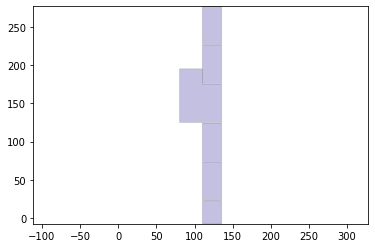

In [ ]:
body = get_bodies(output_file_modified,'body',NUMLAYERS)
body = foldable_robotics.manufacturing.cleanup(body,.02)
body.plot()

In [ ]:
joint_lines= get_hinge_lines(output_file_modified,'joints')
joints = hinge_lines_to_hinges(joint_lines,hinge)
joints = foldable_robotics.manufacturing.cleanup(joints,.02)
joints.plot()

('zero-size array to reduction operation minimum which has no identity',)


In [ ]:
cuts = get_cuts(output_file_modified,'cuts',.02,NUMLAYERS)
#cuts.plot()

In [ ]:
holes = get_holes(output_file_modified,'holes',NUMLAYERS)
#holes.plot()

In [ ]:
hole,dummy = foldable_robotics.manufacturing.calc_hole(joint_lines,w)
hole = hole.to_laminate(NUMLAYERS)
hole<<=.2
hole.plot()

('zero-size array to reduction operation minimum which has no identity',)


<Figure size 432x288 with 0 Axes>

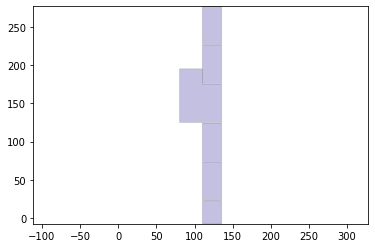

In [ ]:
design2 = body- hole - joints - cuts - holes
design2.plot()

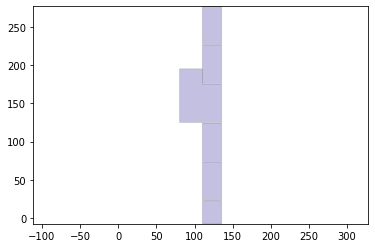

In [ ]:
keepout =  foldable_robotics.manufacturing.keepout_laser(design2)
keepout.plot()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


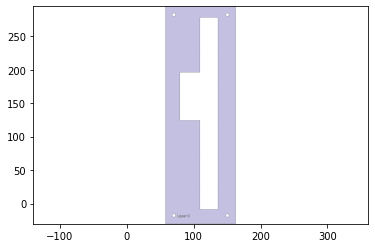

In [ ]:
web,sheet=build_web(design2,keepout,support_width,jig_diameter,jig_hole_spacing,is_adhesive)
web.plot()

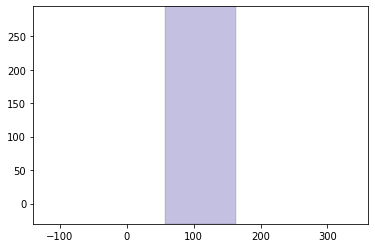

In [ ]:
sheet.plot()

In [ ]:
second_pass_scrap = sheet-keepout
first_pass_scrap = sheet - design2-second_pass_scrap
first_pass_scrap = foldable_robotics.manufacturing.cleanup(first_pass_scrap,.00001)
first_pass_scrap.plot()

('zero-size array to reduction operation minimum which has no identity',)


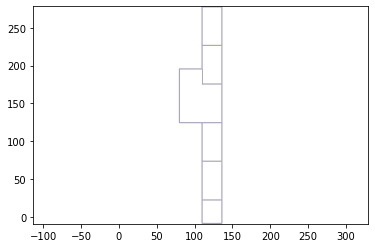

In [ ]:
support = foldable_robotics.manufacturing.support(design2,foldable_robotics.manufacturing.keepout_laser,support_width,support_width/2)
support.plot()

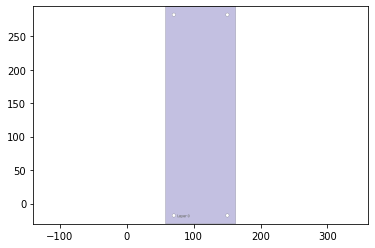

In [ ]:
#Calculate the web by using only the material which can be cut, minus a gap determined by the support width.  Is that the only material you can use?
supported_design = web|design2|support
supported_design.plot()

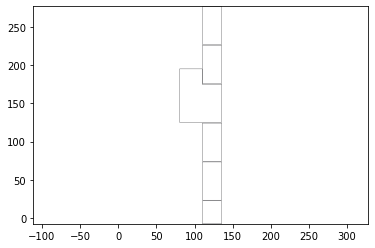

In [ ]:
#cut_line = keepout<<kerf
cut_material = (keepout<<kerf)-keepout
cut_material.plot()

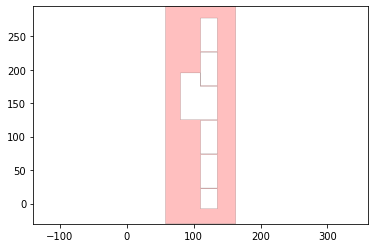

In [ ]:
final_cut = sheet - keepout
final_cut = final_cut[0]
final_cut.plot()

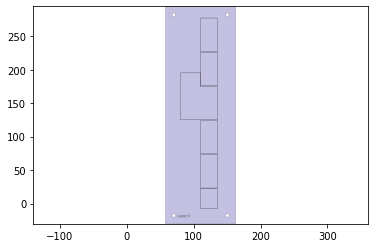

In [ ]:
remaining_material = supported_design-cut_material
remaining_material.plot()

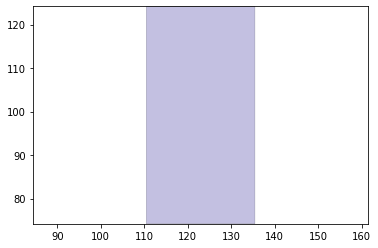

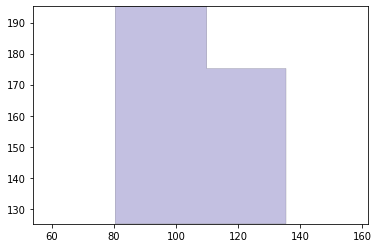

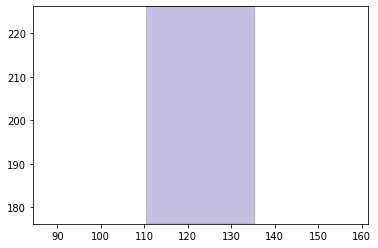

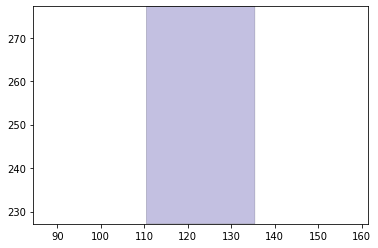

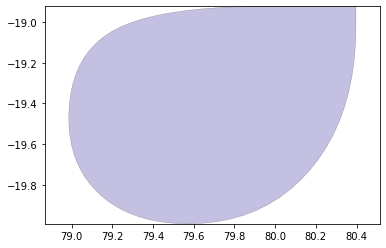

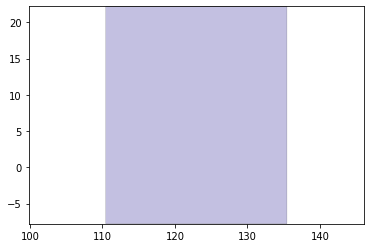

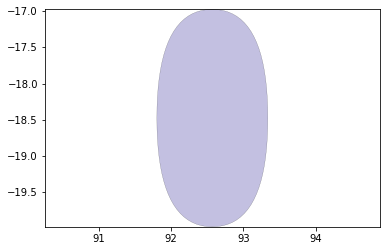

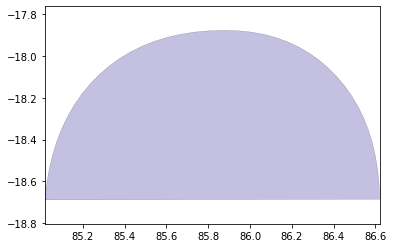

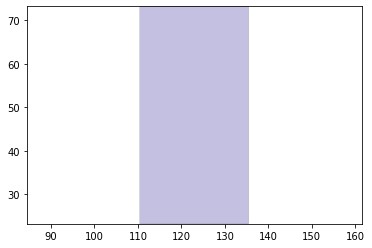

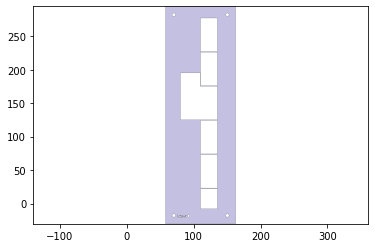

In [ ]:
remaining_parts = foldable_robotics.manufacturing.find_connected(remaining_material,is_adhesive)
for item in remaining_parts:
    item.plot(new=True)

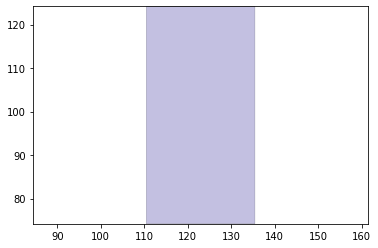

In [ ]:
d3=design2>>1
for item in remaining_parts:
    if not (item&d3).is_null():
        break
item.plot()

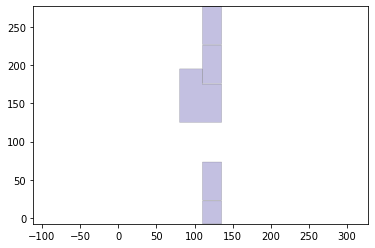

In [ ]:
check = (item^design2)
check>>=1e-5
check.plot()

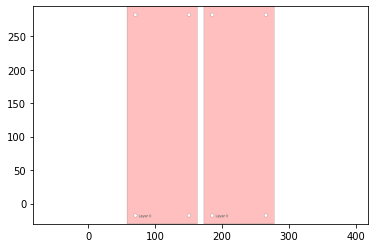

In [ ]:
w,h = supported_design.get_dimensions()
p0,p1 = supported_design.bounding_box_coords()

rigid_layer = supported_design[0] | (supported_design[-1].translate(w+10,0))
rigid_layer.plot()

In [ ]:
l4 = supported_design[3].scale(-1,1)
p2,p3 = l4.bounding_box_coords()
l4 = l4.translate(p0[0]-p2[0]+10+w,p0[1]-p2[1])

adhesive_layer = supported_design[1] | l4
adhesive_layer.plot()

IndexError: ignored

In [ ]:
first_pass = Laminate(rigid_layer,adhesive_layer,supported_design[2])

NameError: ignored

In [ ]:
if check.is_null():
    first_pass.export_dxf(folder+'first_pass_single_layer')
    final_cut.export_dxf(folder+'final_cut_single_layer')

## 5-Layer Design

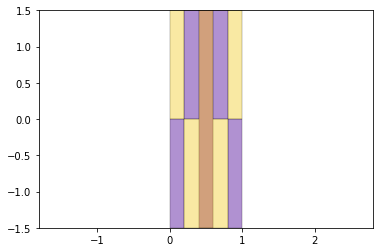

In [17]:
is_adhesive = [False,True,False,True,False]
hinge = foldable_robotics.parts.castellated_hinge1.generate()
w=hinge_width_calculator(135,3) # desired range of motion is +/- 135 degrees, for a 3mm thick laminate
hinge = hinge.scale(1,w)
hinge.plot()


In [18]:
NUMLAYERS = len(hinge)

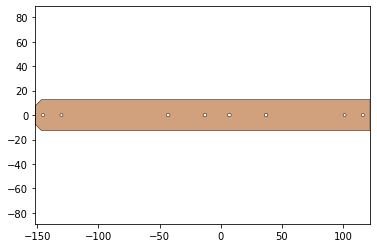

In [19]:
body = get_bodies(output_file_name,'body',NUMLAYERS)
body = foldable_robotics.manufacturing.cleanup(body,.02)
body.plot()

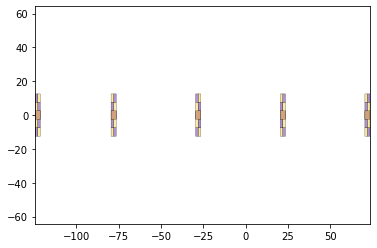

In [20]:
joint_lines= get_hinge_lines(output_file_name,'joints')
joints = hinge_lines_to_hinges(joint_lines,hinge)
joints = foldable_robotics.manufacturing.cleanup(joints,.02)
joints.plot()

In [21]:
cuts = get_cuts(output_file_name,'cuts',.02,NUMLAYERS)
#cuts.plot()

In [22]:
holes = get_holes(output_file_name,'holes',NUMLAYERS)
#holes.plot()

In [23]:
hole,dummy = foldable_robotics.manufacturing.calc_hole(joint_lines,w)
hole = hole.to_laminate(NUMLAYERS)
hole<<=.2
hole.plot()

('zero-size array to reduction operation minimum which has no identity',)


<Figure size 432x288 with 0 Axes>

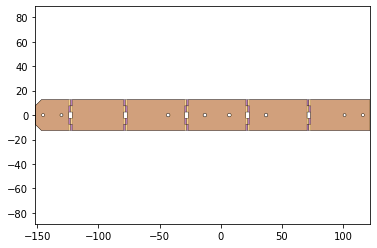

In [24]:
design2 = body- hole - joints - cuts - holes
design2.plot()

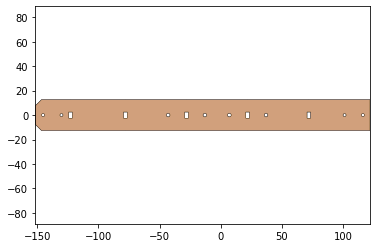

In [25]:
keepout =  foldable_robotics.manufacturing.keepout_laser(design2)
keepout.plot()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


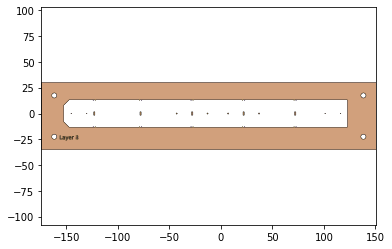

In [26]:
web,sheet=build_web(design2,keepout,support_width,jig_diameter,jig_hole_spacing,is_adhesive)
web.plot()

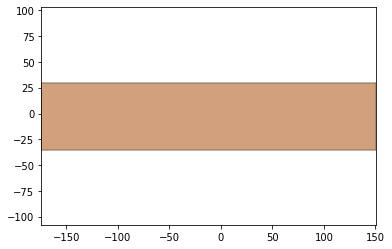

In [27]:
sheet.plot()

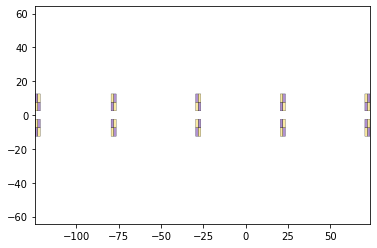

In [28]:
second_pass_scrap = sheet-keepout
first_pass_scrap = sheet - design2-second_pass_scrap
first_pass_scrap = foldable_robotics.manufacturing.cleanup(first_pass_scrap,.00001)
first_pass_scrap.plot()

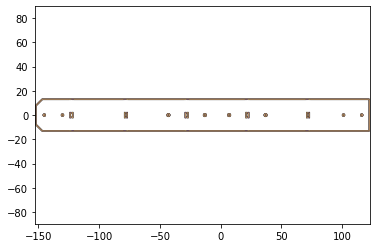

In [29]:
support = foldable_robotics.manufacturing.support(design2,foldable_robotics.manufacturing.keepout_laser,support_width,support_width/2)
support.plot()

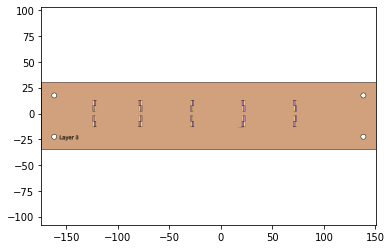

In [30]:
#Calculate the web by using only the material which can be cut, minus a gap determined by the support width.  Is that the only material you can use?
supported_design = web|design2|support
supported_design.plot()

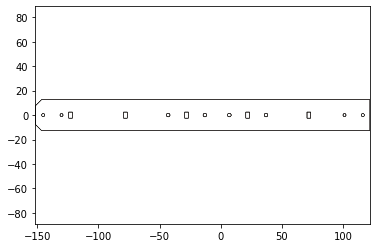

In [31]:
#cut_line = keepout<<kerf
cut_material = (keepout<<kerf)-keepout
cut_material.plot()

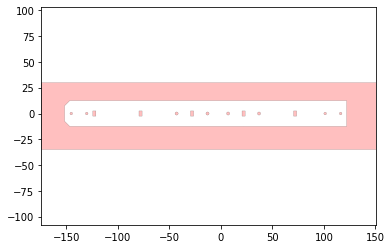

In [32]:
final_cut = sheet - keepout
final_cut = final_cut[0]
final_cut.plot()

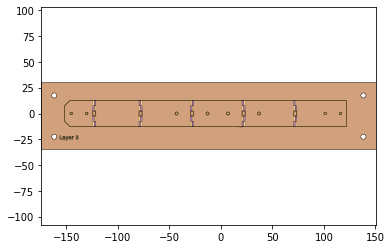

In [33]:
remaining_material = supported_design-cut_material
remaining_material.plot()

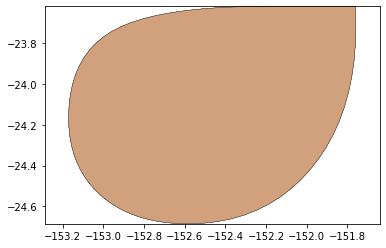

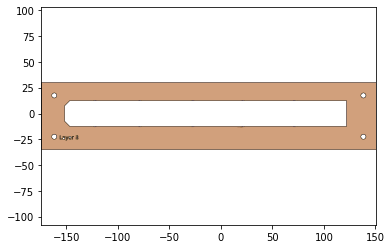

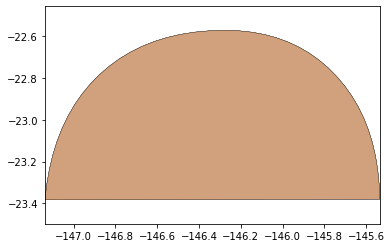

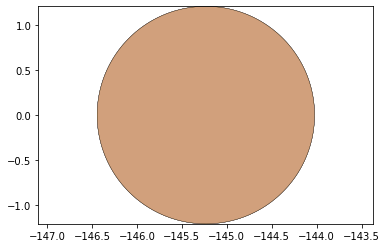

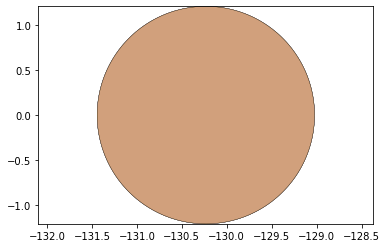

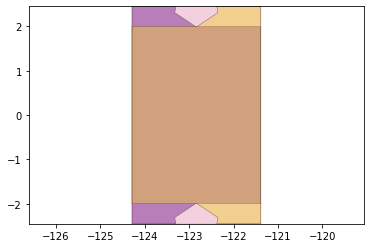

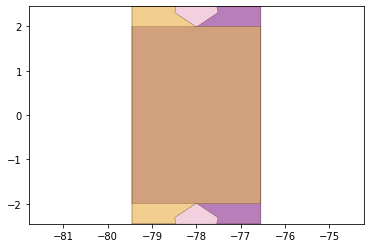

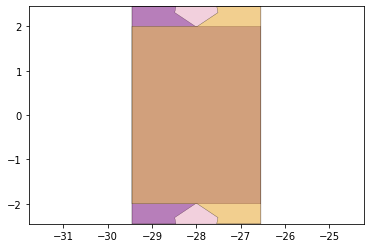

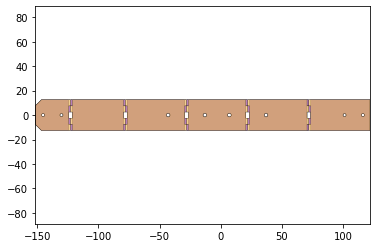

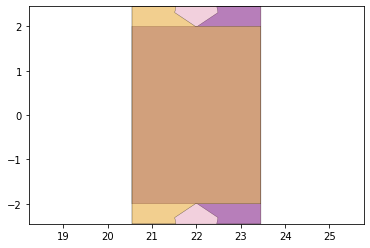

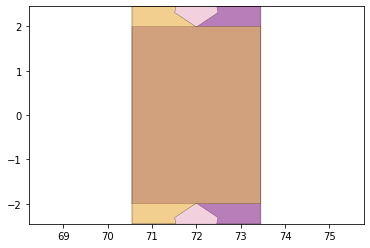

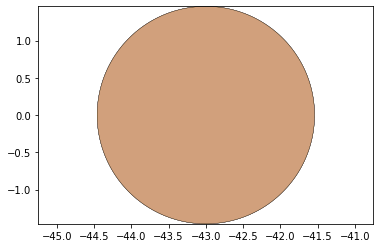

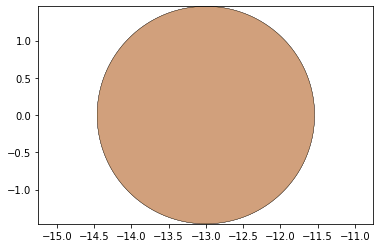

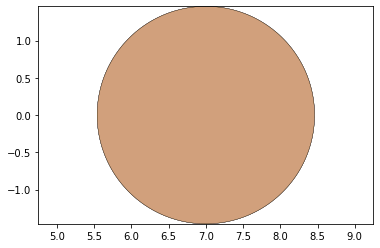

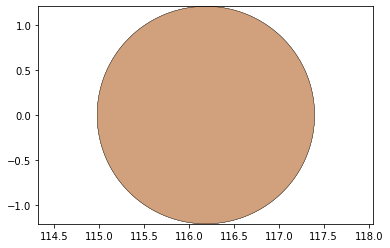

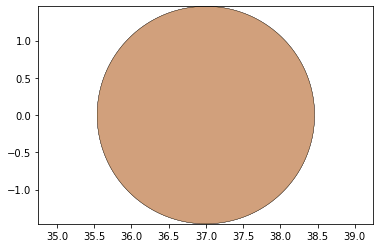

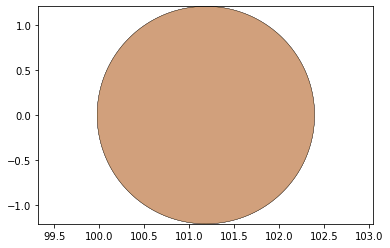

In [35]:
remaining_parts = foldable_robotics.manufacturing.find_connected(remaining_material,is_adhesive)
for item in remaining_parts:
    item.plot(new=True)

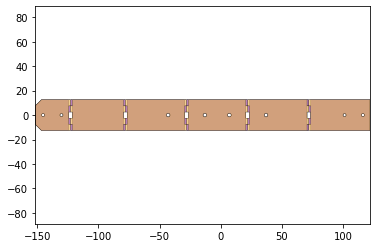

In [43]:
d3=design2>>1
for item in remaining_parts:
    if not (item&d3).is_null():
        break
item.plot()

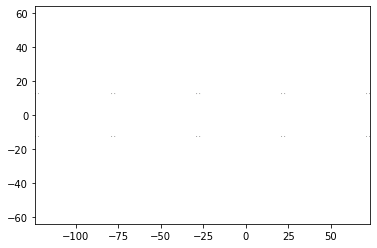

In [46]:
check = (item^design2)
check>>=1e-5
check.plot()

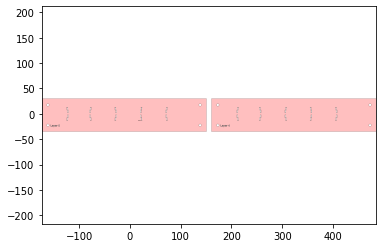

In [38]:
w,h = supported_design.get_dimensions()
p0,p1 = supported_design.bounding_box_coords()

rigid_layer = supported_design[0] | (supported_design[-1].translate(w+10,0))
rigid_layer.plot()

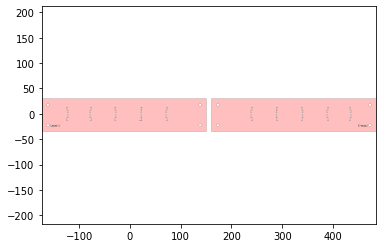

In [39]:
l4 = supported_design[3].scale(-1,1)
p2,p3 = l4.bounding_box_coords()
l4 = l4.translate(p0[0]-p2[0]+10+w,p0[1]-p2[1])

adhesive_layer = supported_design[1] | l4
adhesive_layer.plot()

In [40]:
first_pass = Laminate(rigid_layer,adhesive_layer,supported_design[2])

In [45]:
if check.is_null():
    first_pass.export_dxf('Manufacturing DXFs/first_pass_5_layer')
    final_cut.export_dxf('Manufacturing DXFs/final_cut_5_layer')